# Ernesto Antonio Reyes Ramírez

# Procesamiento de Lenguaje Natural

# Tarea 7: Embeddings and CNNs

### Librerías útiles

In [1]:
# Tools
import os
import time
import random
import shutil
from argparse import Namespace
import matplotlib.pyplot as plt
from typing import Callable, Tuple

# Preprocessing
from nltk.tokenize import TweetTokenizer
from nltk import FreqDist
import pandas as pd
import numpy as np

# PyTorch
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# word embeddings
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

### Revisamos que podamos usar nuestra GPU local para el entrenamiento

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3050 Laptop GPU


### Importamos word2vec

In [3]:
#Cargamos el word2vec
word2vec_dir = "word2vec_col_nlp_class_spring_2023/word2vec_col.txt"

In [4]:
full_txt = pd.read_csv(word2vec_dir, sep = '\r\n', engine = 'python', header = None).loc[:,0].values.tolist()
dimensions = np.array(full_txt[0].split(), dtype = int)
full_txt = full_txt[1:]
word2vec = dict()
for i in range(dimensions[0]):
    embedding = full_txt[i].split(' ')
    word2vec[embedding[0]] = np.float_(embedding[1:])

### Fijamos las semillas

In [5]:
args = Namespace()

args.seed = 1111
random.seed(args.seed) # python seed
np.random.seed(args.seed) # numpy seed
torch.manual_seed(args.seed) # torch seed
torch.backends.cudnn.benchmark = False # causes cuDNN to deterministically select algorithms for Neural Network operations
torch.backends.cudnn.deterministic = True # Use deterministic algorithms instead of non-deterministic where available

### Cargamos la base de datos y la procesamos

In [6]:
!gdown https://drive.google.com/uc?id=1CL2rtDbi7HU1OY8JNrgIlq5TYVhgvAzZ

Downloading...
From: https://drive.google.com/uc?id=1CL2rtDbi7HU1OY8JNrgIlq5TYVhgvAzZ
To: C:\Users\ernes\OneDrive\Documentos\Maestría-CIMAT\Segundo\NLP\Tareas\Tarea7\mex-a3t.zip

  0%|          | 0.00/234k [00:00<?, ?B/s]
100%|##########| 234k/234k [00:00<00:00, 4.01MB/s]


In [7]:
import zipfile
with zipfile.ZipFile("mex-a3t.zip", 'r') as zip_ref:
    zip_ref.extractall("C:/Users/ernes/OneDrive/Documentos/Maestría-CIMAT/Segundo/NLP/Tareas/Tarea7")

In [8]:
args.val_size = 0.1

In [9]:
X_train = pd.read_csv('mex_train.txt', sep='\r\n', engine='python', header=None).loc[:,0]
y_train = pd.read_csv('mex_train_labels.txt', header=None).loc[:,0]
#.values.tolist()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=args.val_size, random_state=args.seed)

X_test = pd.read_csv('mex_val.txt', sep='\r\n', engine='python', header=None).loc[:,0]
y_test = pd.read_csv('mex_val_labels.txt', header=None).loc[:,0]

In [10]:
def get_vocab(corpus: pd.DataFrame,
              tokenizer: Callable[[str], list],
              max_features: int) -> set:
    freq_dist = FreqDist([w.lower() for sentence in corpus\
                                    for w in tokenizer(sentence)])
    
    sorted_words = sortFreqDict(freq_dist)[:min(max_features-1, len(freq_dist))]
    w2idx = {word: i+1 for i, word in enumerate(sorted_words)}

    # Append <pad> token with 0 index
    sorted_words.append('<pad>')
    w2idx['<pad>'] = 0

    return set(sorted_words), w2idx
        
def sortFreqDict(freq_dist: FreqDist) -> list:
    freq_dict = dict(freq_dist)
    return sorted(freq_dict, key=freq_dict.get, reverse=True)

In [11]:
# Set vocab size
args.vocab_size = 5000

tk = TweetTokenizer()
vocab, w2idx = get_vocab(X_train, tk.tokenize, args.vocab_size)

In [12]:
# Vamos a crear la matriz de embeddings con base en word2vec

args.d = 100 # Dimension of word embeddings

matrix_embeddings = np.empty([args.vocab_size,args.d])

for word in vocab:
    if word in word2vec:
        matrix_embeddings[w2idx[word]] = word2vec[word]
    else:
        matrix_embeddings[w2idx[word]] = np.random.rand(args.d)

### Define Dataset, collate_fn and Dataloader

In [13]:
class TweeterDataset(Dataset):
    def __init__(self,
                 X: pd.DataFrame,
                 y: pd.DataFrame,
                 vocab: set,
                 w2idx: dict,
                 tokenizer: Callable[[str], list],
                 max_seq_len: int):
        self.X = X
        self.y = y
        self.vocab = vocab
        self.w2idx = w2idx
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Get sequence of token ids
        sentence = self.X.iloc[idx]
        tokens = [self.w2idx[w] for w in self.tokenizer(sentence) if w in self.vocab]

        # Truncate sequence up to max_seq_len
        truncate_len = min(len(tokens), self.max_seq_len)
        tokens = tokens[:truncate_len]

        # Get true label
        label = self.y.iloc[idx]

        return torch.LongTensor(tokens), torch.LongTensor([label])

In [14]:
def collate_fn(batch):
    # Get X
    batch_tokens = [row[0] for row in batch]
    # Get y
    batch_labels = torch.LongTensor([row[1] for row in batch]).to(torch.float)

    # Pad with 0 (to the rigth) shorter sequences than max_seq_len
    padded_batch_tokens = pad_sequence(batch_tokens, batch_first=True)

    return padded_batch_tokens, batch_labels.unsqueeze(1)

In [15]:
# Set batch size in args
args.batch_size = 64

# Num workers
args.num_workers = 0

# Maximum sequence length
args.max_seq_len = 20

In [16]:
# Training
train_dataset = TweeterDataset(X_train, y_train, vocab, w2idx, tk.tokenize, args.max_seq_len)
train_loader = DataLoader(train_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          collate_fn=collate_fn,
                          shuffle=True)

# Validation
val_dataset = TweeterDataset(X_val, y_val, vocab, w2idx, tk.tokenize, args.max_seq_len)
val_loader = DataLoader(val_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          collate_fn=collate_fn,
                          shuffle=False)

# Test
test_dataset = TweeterDataset(X_test, y_test, vocab, w2idx, tk.tokenize, args.max_seq_len)
test_loader = DataLoader(test_dataset,
                          batch_size=args.batch_size,
                          num_workers=args.num_workers,
                          collate_fn=collate_fn,
                          shuffle=False)

In [17]:
batch_ = next(iter(train_loader))
print(f'X_batch shape: {batch_[0].shape}')
print(f'y_batch shape: {batch_[1].shape}')

X_batch shape: torch.Size([64, 20])
y_batch shape: torch.Size([64, 1])


### Clase de nuestro modelo convolucional

In [18]:
class CNNTextCls(nn.Module):
    def __init__(self, args, embeddings=None, freeze=False):
        super(CNNTextCls, self).__init__()
        
        if embeddings is not None:
            self.emb = nn.Embedding(args.vocab_size, args.d)
            for i in range(embeddings.shape[0]):
                for j in range(embeddings.shape[1]):
                    self.emb.weight.data[i][j] = embeddings[i][j]
            
            if freeze:
                self.emb.weight.requires_grad=False
                
        else:
            self.emb = nn.Embedding(args.vocab_size, args.d)
        
        conv_block_list = []

        for k in args.filter_sizes:
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=args.d, out_channels=args.num_filters, kernel_size=k, stride=1),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=(args.max_seq_len-k+1))
            )
            conv_block_list.append(conv_block)

        self.conv_block_list = nn.ModuleList(conv_block_list)
        self.dropout = nn.Dropout(args.dropout)
        self.fc = nn.Linear(args.num_filters*len(args.filter_sizes), 1)

    def forward(self, x):
        '''
        B: batch size
        L: sequence length
        D: embedding dim
        C: Convolution output channels (number of filters)
        k: Convolution kernel size
        N: Number of convolution blocks

        x shape: (B, L)
        '''
        x = self.emb(x) # (B, L, D)
        x = x.transpose(1,2) # (B, D, L) conv1d expects L in last dimension

        x_filter = []
        for conv_block in self.conv_block_list: # Conv1d -> ReLU -> MaxPool1d
            x_filter.append(conv_block(x).squeeze(2)) # (B, C, L-k+1) -> ReLU -> (B, C, 1) -> (B, C) after squeeze

        x_cat = torch.cat(x_filter, dim=1) # (B, C*N)
        x = self.dropout(x_cat)
        return self.fc(x)

### Función para evaluar el modelo

In [19]:
def model_eval(data, model, gpu=False):
    with torch.no_grad():
        preds, tgts = [], []
        for input, labels in data:
            if gpu:
                input = input.cuda()
            
            outputs = model(input)

            # Get prediction for Accuracy
            y_pred = y_pred = torch.round(torch.sigmoid(outputs.detach())).cpu().numpy()

            tgt = labels.numpy()
            tgts.append(tgt)
            preds.append(y_pred)

    tgts = [e for l in tgts for e in l]
    preds = [e for l in preds for e in l]

    metrics = {
        "accuracy": accuracy_score(tgts, preds),
    }
    
    return metrics

In [20]:
def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))

### Función de entrenamiento

In [21]:
def train(args, model, train_loader, val_loader, optimizer, criterion, scheduler):
    best_metric = 0
    metric_history = []
    train_metric_history = []

    for epoch in range(args.num_epochs):
        epoch_start_time = time.time()
        loss_epoch = []
        training_metrics = []
        model.train()

        for input, labels in train_loader:
            # If GPU available
            if args.use_gpu:
                input = input.cuda()
                labels = labels.cuda()

            # Forward pass
            outputs = model(input)

            loss = criterion(outputs, labels)
            loss_epoch.append(loss.item())

            # Get training metric
            preds = torch.round(torch.sigmoid(outputs.detach())).cpu().numpy()
            training_metrics.append(accuracy_score(labels.cpu().numpy(), preds))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Get metric in training dataset
        mean_epoch_accuracy = np.mean(training_metrics)
        train_metric_history.append(mean_epoch_accuracy)
        
        # Get metric in validation dataset
        model.eval()
        tuning_metric = model_eval(val_loader, model, gpu=args.use_gpu)
        metric_history.append(tuning_metric['accuracy'])

        # Update scheduler
        scheduler.step(tuning_metric['accuracy'])

        # Check for metric improvement
        is_improvement = tuning_metric['accuracy'] > best_metric
        if is_improvement:
            best_metric = tuning_metric['accuracy']
            n_no_improve = 0
        else:
            n_no_improve += 1

        # Save best model if metric improved
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "best_metric": best_metric,
            },
            is_improvement,
            args.savedir,
        )

        # Early stopping
        if n_no_improve >= args.patience:
            print("No improvement. Breaking out of loop.")
            break

        print ('Epoch [{}/{}], Loss: {:.4f} - Train Accuracy: {:.4f} - Val Accuracy: {:.4f} - Epoch time: {:.2f} s'
            .format(epoch+1, args.num_epochs, np.mean(loss_epoch), mean_epoch_accuracy, tuning_metric['accuracy'], (time.time()- epoch_start_time)))
        
    return train_metric_history, metric_history

# CNN-rand

In [24]:
# Model hyperparameters
args.filter_sizes = [3, 4, 5]
args.num_filters = 100
args.dropout = 0.1

# Training hyperparameters
args.lr = 1e-2
args.num_epochs = 100
args.patience = 10

# Scheduler hyperparameters
args.lr_patience = 5
args.lr_factor = 0.5

# Saving directory
args.savedir = 'rand_model'
os.makedirs(args.savedir, exist_ok=True)

# Create model
model = CNNTextCls(args)  #Solo pasamos el modelo 

# Send to GPU
args.use_gpu = torch.cuda.is_available()
if args.use_gpu:
    model.cuda()

# Loss, Optimizer and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=args.lr_patience,
                verbose=True,
                factor=args.lr_factor
            )

In [25]:
start_time = time.time()
train_metric_history_rand, val_metric_history_rand = train(args, model, train_loader, val_loader, optimizer, criterion, scheduler)
print("Total training time: {:.4f} seconds".format((time.time() - start_time)))

Epoch [1/100], Loss: 0.6593 - Train Accuracy: 0.6328 - Val Accuracy: 0.6757 - Epoch time: 1.72 s
Epoch [2/100], Loss: 0.6402 - Train Accuracy: 0.6460 - Val Accuracy: 0.6811 - Epoch time: 0.82 s
Epoch [3/100], Loss: 0.6236 - Train Accuracy: 0.6598 - Val Accuracy: 0.6919 - Epoch time: 0.82 s
Epoch [4/100], Loss: 0.6126 - Train Accuracy: 0.6686 - Val Accuracy: 0.6919 - Epoch time: 0.80 s
Epoch [5/100], Loss: 0.5948 - Train Accuracy: 0.6799 - Val Accuracy: 0.7009 - Epoch time: 0.86 s
Epoch [6/100], Loss: 0.5824 - Train Accuracy: 0.6979 - Val Accuracy: 0.7045 - Epoch time: 0.81 s
Epoch [7/100], Loss: 0.5643 - Train Accuracy: 0.7202 - Val Accuracy: 0.7099 - Epoch time: 0.80 s
Epoch [8/100], Loss: 0.5471 - Train Accuracy: 0.7294 - Val Accuracy: 0.7117 - Epoch time: 0.81 s
Epoch [9/100], Loss: 0.5339 - Train Accuracy: 0.7431 - Val Accuracy: 0.7099 - Epoch time: 0.83 s
Epoch [10/100], Loss: 0.5169 - Train Accuracy: 0.7555 - Val Accuracy: 0.7297 - Epoch time: 0.85 s
Epoch [11/100], Loss: 0.5101 

In [26]:
model.load_state_dict(torch.load('rand_model/model_best.pt')['state_dict'])
model.eval()
test_metric_rand = model_eval(test_loader, model, gpu=args.use_gpu)
print("\nTest Accuracy: {:.4f}".format(test_metric_rand["accuracy"]))


Test Accuracy: 0.7451


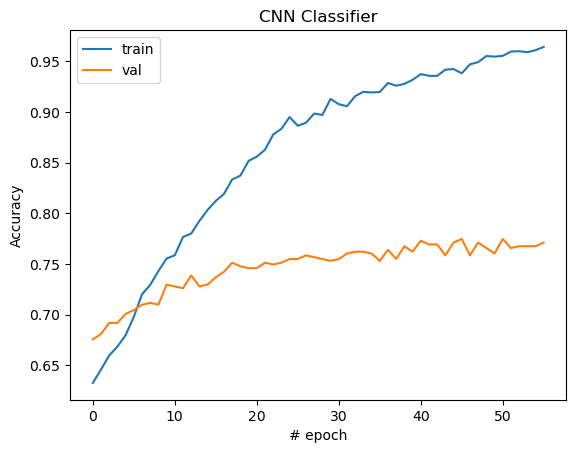

In [27]:
plt.plot(train_metric_history_rand, label='train')
plt.plot(val_metric_history_rand, label='val')
plt.title('CNN Classifier')
plt.ylabel('Accuracy')
plt.xlabel('# epoch')
plt.legend(loc='best')
plt.show()

# CNN-static

In [28]:
# Model hyperparameters
args.filter_sizes = [3, 4, 5]
args.num_filters = 100
args.dropout = 0.1

# Training hyperparameters
args.lr = 1e-2
args.num_epochs = 100
args.patience = 10

# Scheduler hyperparameters
args.lr_patience = 5
args.lr_factor = 0.5

# Saving directory
args.savedir = 'static_model'
os.makedirs(args.savedir, exist_ok=True)

# Create model
model = CNNTextCls(args, matrix_embeddings, freeze=True)  #Aqui al hacer freeze=true hacemos que los embeddings no se entrenen

# Send to GPU
args.use_gpu = torch.cuda.is_available()
if args.use_gpu:
    model.cuda()

# Loss, Optimizer and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=args.lr_patience,
                verbose=True,
                factor=args.lr_factor
            )

In [29]:
start_time = time.time()
train_metric_history_static, val_metric_history_static = train(args, model, train_loader, val_loader, optimizer, criterion, scheduler)
print("Total training time: {:.4f} seconds".format((time.time() - start_time)))

Epoch [1/100], Loss: 1.1686 - Train Accuracy: 0.5911 - Val Accuracy: 0.7315 - Epoch time: 0.90 s
Epoch [2/100], Loss: 0.7077 - Train Accuracy: 0.6545 - Val Accuracy: 0.7279 - Epoch time: 0.86 s
Epoch [3/100], Loss: 0.5387 - Train Accuracy: 0.7365 - Val Accuracy: 0.7586 - Epoch time: 0.88 s
Epoch [4/100], Loss: 0.5065 - Train Accuracy: 0.7508 - Val Accuracy: 0.6973 - Epoch time: 0.88 s
Epoch [5/100], Loss: 0.4765 - Train Accuracy: 0.7729 - Val Accuracy: 0.7495 - Epoch time: 0.86 s
Epoch [6/100], Loss: 0.4426 - Train Accuracy: 0.8004 - Val Accuracy: 0.7748 - Epoch time: 0.86 s
Epoch [7/100], Loss: 0.4222 - Train Accuracy: 0.8089 - Val Accuracy: 0.7387 - Epoch time: 0.86 s
Epoch [8/100], Loss: 0.3954 - Train Accuracy: 0.8226 - Val Accuracy: 0.7423 - Epoch time: 0.84 s
Epoch [9/100], Loss: 0.3585 - Train Accuracy: 0.8427 - Val Accuracy: 0.7279 - Epoch time: 0.88 s
Epoch [10/100], Loss: 0.3412 - Train Accuracy: 0.8547 - Val Accuracy: 0.7459 - Epoch time: 0.84 s
Epoch [11/100], Loss: 0.3095 

In [31]:
model.load_state_dict(torch.load('static_model/model_best.pt')['state_dict'])
model.eval()
test_metric_static = model_eval(test_loader, model, gpu=args.use_gpu)
print("\nTest Accuracy: {:.4f}".format(test_metric_static["accuracy"]))


Test Accuracy: 0.7549


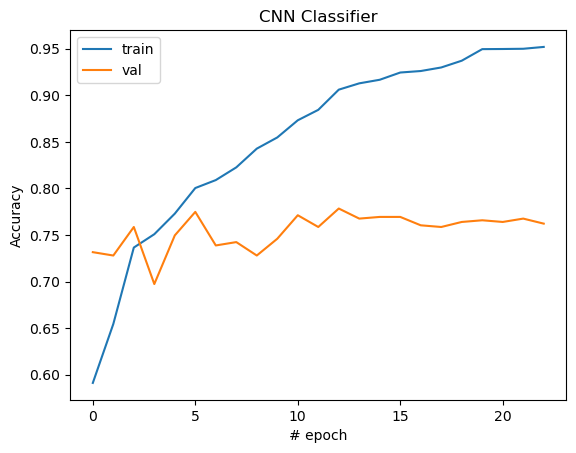

In [32]:
plt.plot(train_metric_history_static, label='train')
plt.plot(val_metric_history_static, label='val')
plt.title('CNN Classifier')
plt.ylabel('Accuracy')
plt.xlabel('# epoch')
plt.legend(loc='best')
plt.show()

# CNN-non-static

In [33]:
# Model hyperparameters
args.filter_sizes = [3, 4, 5]
args.num_filters = 100
args.dropout = 0.1

# Training hyperparameters
args.lr = 1e-2
args.num_epochs = 100
args.patience = 10

# Scheduler hyperparameters
args.lr_patience = 5
args.lr_factor = 0.5

# Saving directory
args.savedir = 'non-static_model'
os.makedirs(args.savedir, exist_ok=True)

# Create model
model = CNNTextCls(args, matrix_embeddings, freeze=False)  #Aqui al hacer freeze=false hacemos que los embeddings se entrenen

# Send to GPU
args.use_gpu = torch.cuda.is_available()
if args.use_gpu:
    model.cuda()

# Loss, Optimizer and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=args.lr_patience,
                verbose=True,
                factor=args.lr_factor
            )

In [34]:
start_time = time.time()
train_metric_history_non, val_metric_history_non = train(args, model, train_loader, val_loader, optimizer, criterion, scheduler)
print("Total training time: {:.4f} seconds".format((time.time() - start_time)))

Epoch [1/100], Loss: 1.1798 - Train Accuracy: 0.5943 - Val Accuracy: 0.3532 - Epoch time: 0.87 s
Epoch [2/100], Loss: 0.7038 - Train Accuracy: 0.6761 - Val Accuracy: 0.5982 - Epoch time: 0.98 s
Epoch [3/100], Loss: 0.5978 - Train Accuracy: 0.7031 - Val Accuracy: 0.7207 - Epoch time: 0.95 s
Epoch [4/100], Loss: 0.5185 - Train Accuracy: 0.7431 - Val Accuracy: 0.7550 - Epoch time: 0.87 s
Epoch [5/100], Loss: 0.4661 - Train Accuracy: 0.7787 - Val Accuracy: 0.7514 - Epoch time: 0.80 s
Epoch [6/100], Loss: 0.4485 - Train Accuracy: 0.7831 - Val Accuracy: 0.6378 - Epoch time: 0.90 s
Epoch [7/100], Loss: 0.4292 - Train Accuracy: 0.8015 - Val Accuracy: 0.7423 - Epoch time: 0.86 s
Epoch [8/100], Loss: 0.3985 - Train Accuracy: 0.8170 - Val Accuracy: 0.7550 - Epoch time: 0.96 s
Epoch [9/100], Loss: 0.3733 - Train Accuracy: 0.8346 - Val Accuracy: 0.7532 - Epoch time: 0.96 s
Epoch [10/100], Loss: 0.3438 - Train Accuracy: 0.8505 - Val Accuracy: 0.7730 - Epoch time: 0.90 s
Epoch [11/100], Loss: 0.3251 

In [35]:
model.load_state_dict(torch.load('non-static_model/model_best.pt')['state_dict'])
model.eval()
test_metric_non = model_eval(test_loader, model, gpu=args.use_gpu)
print("\nTest Accuracy: {:.4f}".format(test_metric_non["accuracy"]))


Test Accuracy: 0.7305


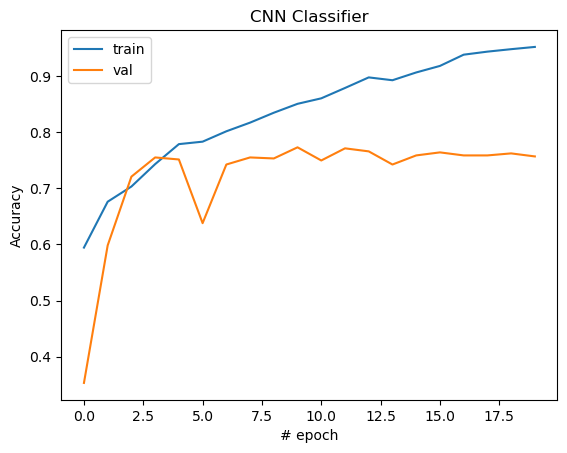

In [36]:
plt.plot(train_metric_history_non, label='train')
plt.plot(val_metric_history_non, label='val')
plt.title('CNN Classifier')
plt.ylabel('Accuracy')
plt.xlabel('# epoch')
plt.legend(loc='best')
plt.show()

### Tabla comparativa entre los tres modelos

Text(0, 0.5, 'Validation Accuracy')

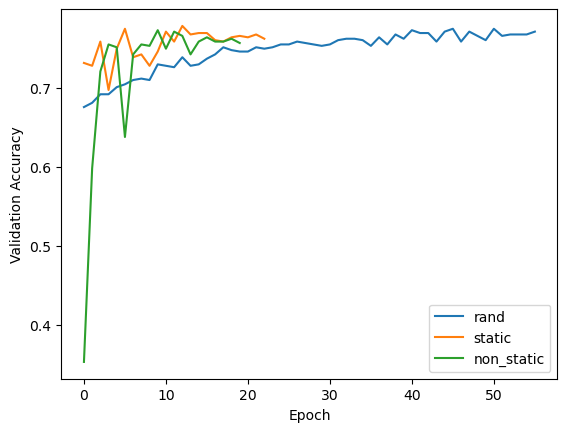

In [37]:
plt.plot(val_metric_history_rand, label='rand')
plt.plot(val_metric_history_static, label='static')
plt.plot(val_metric_history_non, label='non_static')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

# Conclusiones

En este notebook hemos impletado los modelos static y non-static de redes convolucionales para clasifiación de texto utilizando Pytorch. Se nos fue proporcionado el modelo rand. El primero modelo consiste en utilizar embeddings preentrenados y dejarlos fijos durante el entrenamiento mientras que el segundo consiste en entrenar también dichos embeddings. 

Como podemos notar de los resultados de test acurracy para los modelos de rand,static y non-static son 0.7451, 0.7549 y 0.7305 respectivamente. Estos valores no difieren en mucho por lo que ninguno mejorar considerablemente al otro. Pero lo que si podemos notar de la última gráfica comparativa es que si hay una gran diferencia en el número de épocas en el que converge nuestro resultado, teniendo una gran mejora cuando utilizamos embeddings preetrenados a compración de utilizar unos aleatorios, es una diferencia de casi 30 épocas. 

Finalmente, podemos decir que nuestros resultados obtenidos replican muy bien los resultados presentados en el notebook original que nos proprocionó el profe, donde se utilizó tensorflow. 